## What are the optimal skills to learn to maximize earnings for Data Analysts?

### Methodology
1. Calculate number of jobs and median salary for top 10 most popular skills
2. Visualize the median salary vs percentage of each skill appearning in job posting for data analysts
3. Determine if certain technologies are more prevalent

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import ast
import seaborn as sns

# Loading data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data cleanup
df.job_posted_date = pd.to_datetime(df.job_posted_date)
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [25]:
df_DA_US = df[(df['job_country']=='United States') & (df['job_title_short']=='Data Analyst')].copy()
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])
df_DA_US_explode = df_DA_US.explode('job_skills')

In [32]:
df_DA_US_top = df_DA_US_explode.groupby('job_skills').agg(
    skill_count = ('job_skills','count'),
    median_salary = ('salary_year_avg','median')).sort_values(by= 'skill_count', ascending=False)
df_DA_US_top

,skill_count,median_salary
job_skills,,
sql,2508,91000.0
excel,1808,84392.0
python,1431,97500.0
tableau,1364,92875.0
sas,926,90000.0
...,...,...
couchbase,1,160515.0
chainer,1,100000.0
chef,1,85000.0


In [33]:
num_jobs = df_DA_US.job_title_short.count()
num_jobs

4350

In [37]:
df_DA_US_top['skill_percent']=df_DA_US_top['skill_count']/num_jobs*100
percent_limit = 5
df_DA_US_high_demand = df_DA_US_top[df_DA_US_top['skill_percent']>percent_limit]
df_DA_US_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


In [ ]:
# Categorize the skill type based on 'job_type_skills'
df_tech = df['job_type_skills'].copy()
df_tech = df_tech.drop_duplicates()
df_tech = df_tech.dropna()

# Combine all dictionaries into one
tech_dict = {}
for each_row in df_tech:
    row_dict = ast.literal_eval(each_row) # convert str to dictionary and store in 'row_dict'
    for key, value in row_dict.items():
        if key in tech_dict:  # if key exists in tech_dict, add value to this key
            tech_dict[key] += value
        else:                 # if key doesn't exist in tech_dict, add key and value
            tech_dict[key] = value

In [67]:
# Remove duplicates by converting values to SET (set type automatically remove duplicates)
# and transfrom the SET to LIST 
for key, value in tech_dict.items():
    tech_dict[key] = list(set(value))

# Convert the dictionary to DataFrame
df_technology = pd.DataFrame(list(tech_dict.items()), columns = ['technology','skill'])

In [69]:
df_technology = df_technology.explode('skill')
df_technology

,technology,skill
0,analyst_tools,visio
0,analyst_tools,microstrategy
0,analyst_tools,word
0,analyst_tools,msaccess
0,analyst_tools,spss
...,...,...
9,sync,symphony
9,sync,mattermost
9,sync,ringcentral
9,sync,zoom


In [80]:
# Merge 2 data frames based on the skill column
df_plot = df_DA_US_high_demand.merge(df_technology, left_on='job_skills', right_on='skill')


In [81]:
df_plot = df_plot.set_index('skill')
df_plot

,skill_count,median_salary,skill_percent,technology
skill,,,,
sql,2508,91000.00,57.655172,programming
excel,1808,84392.00,41.563218,analyst_tools
python,1431,97500.00,32.896552,programming
tableau,1364,92875.00,31.356322,analyst_tools
sas,926,90000.00,21.287356,analyst_tools
sas,926,90000.00,21.287356,programming
r,893,92500.00,20.528736,programming
power bi,838,90000.00,19.264368,analyst_tools
powerpoint,462,85000.00,10.620690,analyst_tools


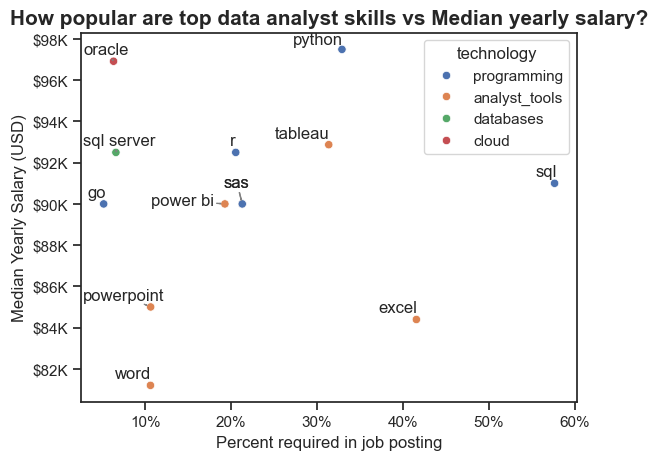

In [88]:
from adjustText import adjust_text

sns.scatterplot(df_plot, x = 'skill_percent', y = 'median_salary', hue='technology')
sns.set_theme(style='ticks')

plt.title('How popular are top data analyst skills vs Median yearly salary?', fontsize = 15,fontweight='bold')
plt.xlabel('Percent required in job posting')
plt.ylabel('Median Yearly Salary (USD)')
# Prepare texts for adjustText:
texts = []
for i, txt in enumerate(df_plot.index):
    texts.append(plt.text(df_plot['skill_percent'].iloc[i], df_plot['median_salary'].iloc[i],txt, ha='right', va='bottom')) # Getting the text value into the variable:
# Adjust the text to avoid overlap
adjust_text(
    texts,
    arrowprops = dict(arrowstyle = "->", color = 'grey', lw=1)
    )

# Get current axis to use ax.yaxis.set_major_formatter (to modify the ylabel)
ax = plt.gca() 
# Apply the plt.FuncFormatter(x, pos) to format the y axis value
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')) # Format the y-axis value
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x)}%'))

plt.show()